🚀 고퀄리티 광고 파이프라인 시작: image.png

[Stage 1] 배경 제거 모델 로딩 (BiRefNet)...
✂️ 바나나 누끼 따는 중...

[Stage 2] 배경 생성 모델 로딩 (SDXL Inpainting)...


Loading pipeline components...: 100%|██████████| 7/7 [00:02<00:00,  3.50it/s]


🎨 나무 테이블 배경 그리는 중...


100%|██████████| 40/40 [00:15<00:00,  2.66it/s]



[Stage 3] 조명 통합 모델 로딩 (SDXL Img2Img)...


Loading pipeline components...: 100%|██████████| 7/7 [00:02<00:00,  3.05it/s]


✨ 바나나와 배경의 조명을 자연스럽게 합치는 중...


100%|██████████| 6/6 [00:02<00:00,  2.84it/s]



[Stage 4] 한글 텍스트 합성 중...


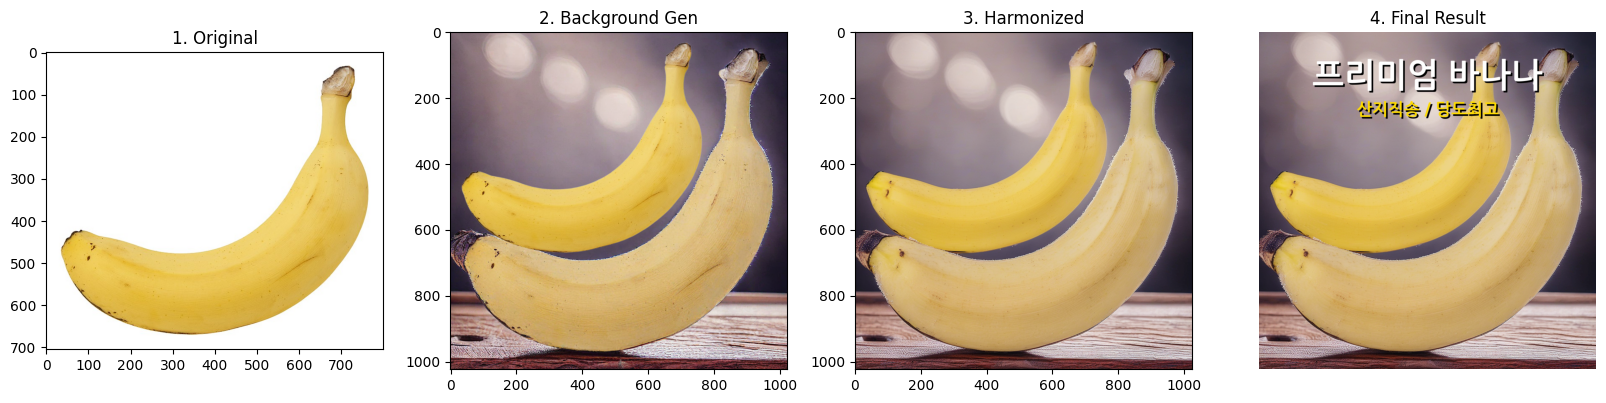

✅ 모든 작업 완료! 결과 저장: final_banana_ad.png


In [4]:
import torch
import gc
import os
import requests
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw, ImageFont, ImageFilter
from torchvision import transforms
from transformers import AutoModelForImageSegmentation
from diffusers import AutoPipelineForInpainting, AutoPipelineForImage2Image
from diffusers.utils import load_image

# ==========================================
# 🛠️ 유틸리티 함수
# ==========================================
def flush_memory():
    """모델을 내리고 GPU 메모리를 강제로 비웁니다."""
    gc.collect()
    torch.cuda.empty_cache()
    # print("🧹 GPU 메모리 정리 완료") 

# ==========================================
# 🛠️ 폰트 다운로드 함수 (수정됨: 확실한 URL)
# ==========================================
def download_font_force(font_name="NanumGothic-Bold.ttf"):
    # Google Fonts의 정확한 Raw 파일 주소
    font_url = "https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Bold.ttf"
    
    # 1. 기존에 파일이 있는데 사이즈가 0이거나 잘못된 경우 삭제
    if os.path.exists(font_name):
        if os.path.getsize(font_name) < 1000: # 1kb 미만이면 잘못된 파일
            print(f"🗑️ 손상된 폰트 파일 삭제 후 다시 받습니다: {font_name}")
            os.remove(font_name)
    
    # 2. 다운로드 수행
    if not os.path.exists(font_name):
        print(f"📥 한글 폰트 다운로드 중... ({font_name})")
        try:
            r = requests.get(font_url, timeout=10)
            r.raise_for_status() # 에러 체크
            with open(font_name, 'wb') as f:
                f.write(r.content)
            print("✅ 폰트 다운로드 성공!")
        except Exception as e:
            print(f"❌ 폰트 다운로드 실패: {e}")
            return None
            
    return font_name


# ==========================================
# 🚀 STAGE 1: AI 배경 제거 (BiRefNet) - 수정됨
# ==========================================
def step1_remove_background(image_path):
    print("\n[Stage 1] 배경 제거 모델 로딩 (BiRefNet)...")
    birefnet = AutoModelForImageSegmentation.from_pretrained("ZhengPeng7/BiRefNet", trust_remote_code=True)
    birefnet.to("cuda").eval()
    
    print("✂️ 바나나 누끼 따는 중...")
    original_img = load_image(image_path).convert("RGB")
    w, h = original_img.size
    
    transform_image = transforms.Compose([
        transforms.Resize((1024, 1024)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    input_tensor = transform_image(original_img).unsqueeze(0).to("cuda")
    
    with torch.no_grad():
        preds = birefnet(input_tensor)[-1].sigmoid().cpu()
    
    # [수정된 부분] preds에서 pred를 정의하는 줄을 추가했습니다.
    pred = preds[0].squeeze() 
    
    pred_pil = transforms.ToPILImage()(pred)
    mask = pred_pil.resize((w, h))
    
    foreground = original_img.copy()
    foreground.putalpha(mask)
    
    del birefnet
    flush_memory()
    return original_img, foreground, mask

# ==========================================
# 🚀 STAGE 2: AI 배경 생성 (SDXL Inpainting)
# ==========================================
def step2_generate_background(original_img, mask_image):
    print("\n[Stage 2] 배경 생성 모델 로딩 (SDXL Inpainting)...")
    pipeline = AutoPipelineForInpainting.from_pretrained(
        "diffusers/stable-diffusion-xl-1.0-inpainting-0.1",
        torch_dtype=torch.float16, variant="fp16", use_safetensors=True
    ).to("cuda")
    
    print("🎨 나무 테이블 배경 그리는 중...")
    # 마스크 반전 (검은색=바나나보존, 흰색=배경그리기)
    inverted_mask = Image.eval(mask_image, lambda x: 255 - x)
    
    generator = torch.Generator(device="cuda").manual_seed(42)
    
    prompt = "high quality product photography, a banana sitting on a rustic wooden table, soft sunlight from side, bokeh background of a sunlit kitchen, 8k, realistic texture, deep shadows"
    negative_prompt = "cartoon, illustration, white background, ugly, deformed, watermark, text"
    
    bg_generated = pipeline(
        prompt=prompt, negative_prompt=negative_prompt, image=original_img, mask_image=inverted_mask,
        strength=1.0, guidance_scale=7.5, num_inference_steps=40, generator=generator
    ).images[0]
    
    del pipeline
    flush_memory()
    return bg_generated

# ==========================================
# ✨ STAGE 3: 조명 통합 (Harmonization)
# ==========================================
def step3_harmonize_lighting(composite_image):
    print("\n[Stage 3] 조명 통합 모델 로딩 (SDXL Img2Img)...")
    pipeline = AutoPipelineForImage2Image.from_pretrained(
        "stabilityai/stable-diffusion-xl-base-1.0",
        torch_dtype=torch.float16, variant="fp16", use_safetensors=True
    ).to("cuda")
    
    print("✨ 바나나와 배경의 조명을 자연스럽게 합치는 중...")
    generator = torch.Generator(device="cuda").manual_seed(42)
    
    prompt = "high quality product photography, a banana sitting naturally on a rustic wooden table, consistent realistic lighting, soft shadows connecting the fruit to the table, 8k, highly detailed"
    negative_prompt = "cartoon, illustration, ugly, deformed, unrealistic lighting, floating"
    
    harmonized_image = pipeline(
        prompt=prompt, negative_prompt=negative_prompt, image=composite_image,
        strength=0.20, # 자연스러움을 위해 강도를 낮게 설정 (0.2~0.25)
        guidance_scale=7.5, num_inference_steps=30, generator=generator
    ).images[0]
    
    del pipeline
    flush_memory()
    return harmonized_image

# ==========================================
# ✍️ STAGE 4: 한글 합성 (재정의)
# ==========================================
def step4_add_korean_text(image):
    print("\n[Stage 4] 한글 텍스트 합성 중...")
    
    # 수정된 다운로드 함수 사용
    font_path = download_font_force()
    
    draw = ImageDraw.Draw(image)
    img_w, img_h = image.size
    
    # 폰트 크기 설정 (이미지 높이의 10% 정도)
    font_size = int(img_h * 0.1)
    
    # 폰트 로드 시도
    try:
        if font_path and os.path.exists(font_path):
            font = ImageFont.truetype(font_path, font_size)
            font_small = ImageFont.truetype(font_path, int(font_size * 0.5))
        else:
            raise Exception("폰트 파일 없음")
    except Exception as e:
        print(f"⚠️ 폰트 로드 에러: {e}")
        print("기본 폰트를 사용하므로 한글이 깨질 수 있습니다.")
        font = ImageFont.load_default()
        font_small = ImageFont.load_default()

    text1 = "프리미엄 바나나"
    text2 = "산지직송 / 당도최고"
    
    # 텍스트 위치 계산 (상단 중앙)
    # textbbox가 없는 구형 PIL 버전을 대비해 예외처리
    try:
        bbox1 = draw.textbbox((0, 0), text1, font=font)
        text1_w = bbox1[2] - bbox1[0]
        text1_h = bbox1[3] - bbox1[1]
    except:
        text1_w, text1_h = draw.textsize(text1, font=font)

    x1 = (img_w - text1_w) / 2
    y1 = img_h * 0.08 
    
    try:
        bbox2 = draw.textbbox((0, 0), text2, font=font_small)
        text2_w = bbox2[2] - bbox2[0]
    except:
        text2_w, _ = draw.textsize(text2, font=font_small)
        
    x2 = (img_w - text2_w) / 2
    y2 = y1 + text1_h + 30 # 간격 조정

    # 가독성을 위한 그림자 (검은색 반투명)
    shadow_offset = 5
    draw.text((x1 + shadow_offset, y1 + shadow_offset), text1, font=font, fill=(0,0,0,180))
    draw.text((x2 + shadow_offset, y2 + shadow_offset), text2, font=font_small, fill=(0,0,0,180))
    
    # 메인 글씨
    draw.text((x1, y1), text1, font=font, fill=(255,255,255))
    draw.text((x2, y2), text2, font=font_small, fill=(255, 220, 0)) # 노란색 포인트

    return image

# ==========================================
# 🏁 메인 파이프라인 실행
# ==========================================
def run_ultimate_pipeline(image_path):
    print(f"🚀 고퀄리티 광고 파이프라인 시작: {image_path}")
    
    # 1. 배경 제거 & 2. 배경 생성
    original, foreground, mask = step1_remove_background(image_path)
    bg_generated = step2_generate_background(original, mask)
    
    # 1차 합성 (단순 붙이기 - Stage 3 입력용)
    composite_v1 = bg_generated.copy()
    composite_v1.paste(foreground, (0, 0), foreground)
    
    # 3. 조명 통합 (자연스러움 UP)
    harmonized_image = step3_harmonize_lighting(composite_v1)
    
    # 4. 한글 추가 (완성도 UP)
    final_result = step4_add_korean_text(harmonized_image.copy())
    
    # 결과 시각화
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 4, 1); plt.imshow(original); plt.title("1. Original")
    plt.subplot(1, 4, 2); plt.imshow(composite_v1); plt.title("2. Background Gen")
    plt.subplot(1, 4, 3); plt.imshow(harmonized_image); plt.title("3. Harmonized")
    plt.subplot(1, 4, 4); plt.imshow(final_result); plt.title("4. Final Result")
    plt.axis("off")
    plt.show()
    
    final_result.save("final_banana_ad.png")
    print("✅ 모든 작업 완료! 결과 저장: final_banana_ad.png")
    
    flush_memory()

# 실행
run_ultimate_pipeline("image.png")